# Training a Classifier on the *Salammbô* Dataset with PyTorch
Author: Pierre Nugues

We first import some modules

In [1]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

We set a seed to have reproducible results

In [2]:
random.seed(4321)
torch.manual_seed(4321)

### Reading the dataset
We can read the data from a file with the svmlight format or directly create numpy arrays

In [3]:
X = torch.Tensor(
    [[35680, 2217], [42514, 2761], [15162, 990], [35298, 2274],
     [29800, 1865], [40255, 2606], [74532, 4805], [37464, 2396],
     [31030, 1993], [24843, 1627], [36172, 2375], [39552, 2560],
     [72545, 4597], [75352, 4871], [18031, 1119], [36961, 2503],
     [43621, 2992], [15694, 1042], [36231, 2487], [29945, 2014],
     [40588, 2805], [75255, 5062], [37709, 2643], [30899, 2126],
     [25486, 1784], [37497, 2641], [40398, 2766], [74105, 5047],
     [76725, 5312], [18317, 1215]
     ])

y = torch.Tensor(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Scaling the Data
Scaling and normalizing are usually very significant with neural networks. We use sklean transformers. They consist of two main methods: `fit()` and `transform()`.

### Normalizing

In [4]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
X_norm = normalizer.fit_transform(X)
X_norm[:4]

array([[0.9980751 , 0.06201605],
       [0.99789774, 0.06480679],
       [0.9978751 , 0.06515607],
       [0.9979313 , 0.06428964]], dtype=float32)

### Standardizing

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X_norm)
X_scaled[:4]

array([[ 1.6832309 , -1.7197776 ],
       [ 0.5732034 , -0.5614551 ],
       [ 0.431466  , -0.41648194],
       [ 0.7831985 , -0.7761007 ]], dtype=float32)

## Creating PyTorch Tensors
PyTorch has its own implementation of matrices called tensors. They are more or less equivalent to NumPy arrays. We need to convert our dataset to these tensors and represent $\mathbf{y}$  as a column vector

In [6]:
Y = y.reshape((-1, 1))
Y[:4]

tensor([[0.],
        [0.],
        [0.],
        [0.]])

In [7]:
X_scaled = torch.Tensor(X_scaled)
X_scaled[:4]

tensor([[ 1.6832, -1.7198],
        [ 0.5732, -0.5615],
        [ 0.4315, -0.4165],
        [ 0.7832, -0.7761]])

## Creating a Model

We define a classifier equivalent to a logistic regression

In [9]:
input_dim = X.shape[1]
input_dim

2

In [10]:
model = nn.Sequential(
    torch.nn.Linear(input_dim, 1),
    torch.nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

We create the model. To try the network with one hidden layer, set `complex` to true

In [11]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[-0.5296,  0.0533]], requires_grad=True),
 Parameter containing:
 tensor([0.2212], requires_grad=True))

In [12]:
loss_fn = nn.BCELoss()    # binary cross entropy loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Fitting the Model
We will show three methods: batch gradient descent, stochastic descent, and minibatches

### Batch Gradient Descent

We fit the whole dataset (batch gradient descent)

In [13]:
loss_history = []
model.train()               # sets PyTorch in the train mode
for epoch in range(10000):
    Y_pred = model(X_scaled)
    loss = loss_fn(Y_pred, Y)
    optimizer.zero_grad()   # resets the gradients
    loss.backward()         # gradient backpropagation
    optimizer.step()        # weight updates
    loss_history += [loss.item()]

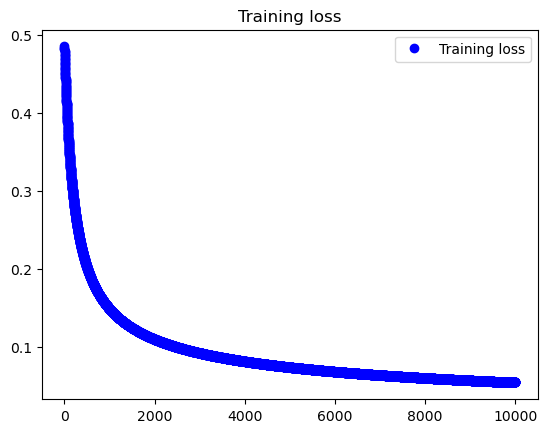

In [14]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

### Stochastic Gradient Descent

or, we fit the model with a batch size of one item (stochastic gradient descent)

In [15]:
model[0].reset_parameters()

In [16]:
loss_history = []
model.train()
for epoch in range(500):
    loss_train = 0
    for x_scaled, y in zip(X_scaled, Y):
        y_pred = model(x_scaled)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    loss_train /= len(Y)
    loss_history += [loss_train]

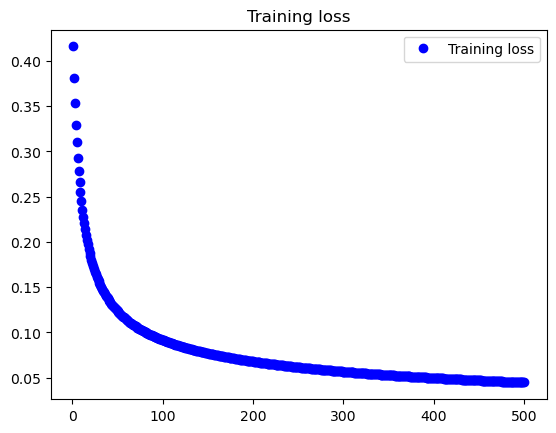

In [17]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

### Minibatch Gradient Descent

Or we fit it with mini-batches, first with a simple inner loop

In [18]:
BATCH_SIZE = 4

In [19]:
model[0].reset_parameters()

In [20]:
loss_history = []
model.train()
for epoch in range(500):
    # Would need to shuffle X and y
    loss_train = 0
    for i in range(0, X_scaled.size()[0], BATCH_SIZE):
        Y_batch_pred = model(X_scaled[i:i + BATCH_SIZE])
        loss = loss_fn(Y_batch_pred, Y[i:i + BATCH_SIZE])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += BATCH_SIZE * loss.item()
    loss_history += [loss_train/len(Y)]

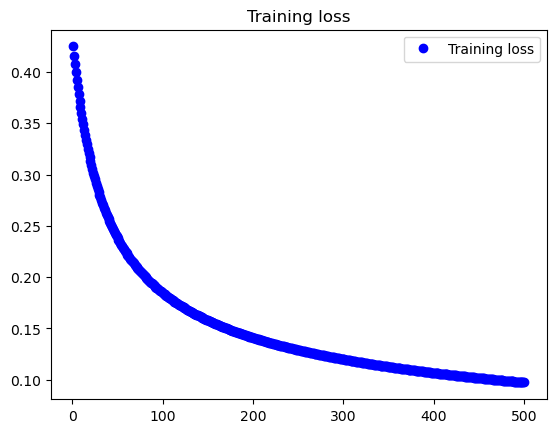

In [21]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

Then with a dataloader

In [22]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_scaled, Y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [23]:
model[0].reset_parameters()

In [24]:
loss_history = []
model.train()
for epoch in range(500):
    loss_train = 0
    for X_scaled_batch, Y_batch in dataloader:
        Y_batch_pred = model(X_scaled_batch)
        loss = loss_fn(Y_batch_pred, Y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += BATCH_SIZE * loss.item()
    loss_history += [loss_train/len(Y)]

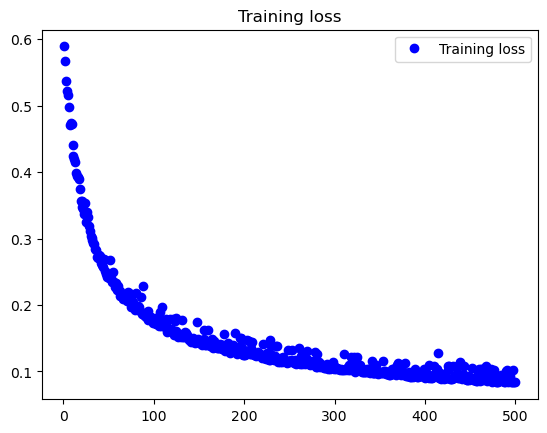

In [25]:
epochs = range(1, len(loss_history) + 1)
plt.plot(epochs, loss_history, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

## The weights

In [26]:
list(model.parameters())

[Parameter containing:
 tensor([[-2.4482,  2.3132]], requires_grad=True),
 Parameter containing:
 tensor([0.2588], requires_grad=True)]

Also in the form of a dictionary

In [27]:
model.state_dict()

OrderedDict([('0.weight', tensor([[-2.4482,  2.3132]])),
             ('0.bias', tensor([0.2588]))])

## Prediction

### Probabilities

We compute the probabilities to belong to class 1 for all the training set

In [28]:
model.eval()
y_pred_proba = model(X_scaled)
y_pred_proba[:4]

tensor([[0.0004],
        [0.0799],
        [0.1467],
        [0.0307]], grad_fn=<SliceBackward0>)

We recompute it with matrices

In [29]:
m_params = list(model.parameters())

In [30]:
torch.sigmoid(X_scaled @ m_params[0].T + m_params[1])[:4]

tensor([[0.0004],
        [0.0799],
        [0.1467],
        [0.0307]], grad_fn=<SliceBackward0>)

### Classes

In [31]:
def predict_class(y_pred_proba):
    y_pred = torch.zeros(y_pred_proba.shape[0])
    for i in range(y_pred_proba.shape[0]):
        if y_pred_proba[i][0] >= 0.5:
            y_pred[i] = 1
    return y_pred

In [32]:
y_pred = predict_class(y_pred_proba)
y_pred

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Loss

We recompute the loss for the first element

In [32]:
y[0]

tensor(1.)

Predicted probability of this element

In [33]:
1 - y_pred_proba[0]

tensor([0.9996], grad_fn=<RsubBackward1>)

Loss

In [34]:
-torch.log(1 - y_pred_proba[0])

tensor([0.0004], grad_fn=<NegBackward0>)

And PyTorch loss

In [33]:
loss_fn(y_pred_proba[0], Y[0])

tensor(0.0004, grad_fn=<BinaryCrossEntropyBackward0>)

For the whole dataset. The probabilities

In [36]:
((1 - Y) * (1 - y_pred_proba) + Y * y_pred_proba)[:4]

tensor([[0.9996],
        [0.9201],
        [0.8533],
        [0.9693]], grad_fn=<SliceBackward0>)

The loss

In [37]:
-torch.sum(torch.log((1 - Y) * (1 - y_pred_proba) + Y * y_pred_proba))/Y.shape[0]

tensor(0.0820, grad_fn=<DivBackward0>)

PyTorch loss

In [38]:
loss_fn(y_pred_proba, Y)

tensor(0.0820, grad_fn=<BinaryCrossEntropyBackward0>)

## Evaluation

In [39]:
from sklearn.metrics import classification_report

print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        15
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



We computed the accuracy from the training set. This is not a good practice. We should use a dedicated test set instead.